### Simple MultiAI Agent Architecture...

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="groq:llama-3.3-70b-versatile")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000218B142CB60>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000218B136A6C0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
from typing import TypedDict, Annotated, List, Literal

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, MessagesState, END
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [4]:
## Define the state
class AgentState(MessagesState):
    next_agent:str   # which agent should go next

In [5]:
## Create Web Search Tool

@tool
def search_web(query: str) -> str:
    """
    Search the web for a query.
    """
    search = TavilySearchResults(max_results=3)
    
    results = search.invoke(query)
    
    return str(results)

In [6]:
## Create a Writer Summary Tool

@tool
def write_summary(content: str) -> str:
    """
    Write a summary of the provided content.
    """
    # Simple summary generation
    summary = f"📝Summary of findings:\n\n{content[:500]}..."
    
    return summary

In [7]:
## Define the Web Search agent that uses the search_web tool
def researcher_agent(state: AgentState):
    """
    Researcher agent that searches for user queries using the search_web tool.
    """
    
    messages = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Define LLM with search_web tool
    researcher_llm = llm.bind_tools([search_web])
    
    # Call the LLM with the system message and user messages
    response = researcher_llm.invoke([system_msg] + messages)
    
    # Return the response and route to writer
    return {
        "messages": [response],
        "next_agent": "Writer"
    }

In [8]:
## Define the Writer agent that summarizes the search results
def writer_agent(state: AgentState):
    """
    Writer agent that creates summaries
    """
    
    messages = state["messages"]
    
    # Add system message
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [9]:
# # Tool executor node
# def tool_executor(state: AgentState):
#     """
#     Executes any pending tool calls
#     """
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     # Check if there are tool calls to execute
#     if hasattr(last_message, "tool_calls") and last_message.tool_calls:
#         # Create tool node and execute
#         tool_node = ToolNode([search_web, write_summary])
#         response = tool_node.invoke(state)
#         return response
    
#     # If no tool calls, just return the state
#     return state

In [10]:
## Define the StateGraph for the multi-agent system
workflow_builder = StateGraph(MessagesState)

In [11]:
## ADD the nodes to the workflow
workflow_builder.add_node("Researcher", researcher_agent)
workflow_builder.add_node("Writer", writer_agent)

In [12]:
## ADD ALL Edeges and Define The Flow
workflow_builder.set_entry_point("Researcher")
workflow_builder.add_edge("Researcher", "Writer")
workflow_builder.add_edge("Writer", END)

In [13]:
## Compile the workflow
workflow = workflow_builder.compile()

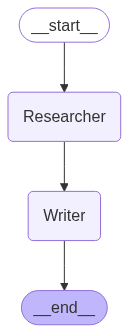

In [14]:
workflow

In [15]:
response = workflow.invoke({
    "messages": "Reasearch about the usecase of agentic ai in business"
})

response

{'messages': [HumanMessage(content='Reasearch about the usecase of agentic ai in business', additional_kwargs={}, response_metadata={}, id='0d27da84-bf1f-4626-b84f-1b1ca68adfd8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'pcb898fhf', 'function': {'arguments': '{"query":"agentic AI in business use cases"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 245, 'total_tokens': 265, 'completion_time': 0.070515392, 'prompt_time': 0.034546532, 'queue_time': 0.08667401999999999, 'total_time': 0.105061924}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--27242f92-4998-408d-993a-15aa764c8252-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'agentic AI in business use cases'}, 'id': 'pcb898fhf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 2

In [18]:
print(response["messages"][-1].content)

 

**Summary of Findings: Agentic AI in Business**

Agentic AI refers to artificial intelligence systems that can perform tasks autonomously, making decisions and taking actions without human intervention. In the business world, agentic AI has numerous use cases, transforming the way companies operate and interact with customers. Here are some key findings:

**Use Cases:**

1. **Customer Service**: Agentic AI-powered chatbots and virtual assistants provide 24/7 customer support, answering queries, and resolving issues autonomously.
2. **Predictive Maintenance**: Agentic AI analyzes equipment sensor data to predict maintenance needs, reducing downtime and increasing overall efficiency.
3. **Supply Chain Optimization**: Agentic AI optimizes supply chain operations, such as demand forecasting, inventory management, and logistics routing, to minimize costs and maximize profits.
4. **Marketing and Sales**: Agentic AI helps personalize customer experiences, automates lead generation, and opt